# Part 2: creating and importing image features

Within GridFix, a "feature" defines a two-step transformation on an image and an associated RegionSet. In the first step, each input image may be transformed in a way that is useful for the respective analysis, such as generating a contrast map or edge density image. The resulting feature map (which is stored and processed as a numpy array) is then summarized using the RegionSet so that one feature value per region is returned. 

As an example, the most simple feature object is _LuminanceFeature_, which transforms an RGB image into a greyscale luminance image (using the same process as Matlab's _rgb2gray.m_) and then returns the mean luminance value for each region of interest / grid cell.

In [1]:
# Import GridFix toolbox and related modules

%matplotlib inline
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

from gridfix import *

__Loading data:__ In oder to be able to create and import various image features, we will first load the same example images used in part 1 and again define a 8-by-6 grid for evaluation. If we leave out all the plotting and example code, that's just two lines of Python code: 

In [2]:
TA_images = ImageSet('TA_images/TA_images.tsv', label='TA_images')
grid = GridRegionSet(size=TA_images.size, gridsize=(16,10), label='TA_images')

## 1. Creating features from images

GridFix has some built-in image features than can be used directly on input images. To illustrate, let's create the aforementioned LuminanceFeature for our input images and the previously defined grid. `print()`ing a Feature object will show details on the Feature itself as well as the associated datasets. 

In [3]:
fLum = LuminanceFeature(grid, TA_images)
print(fLum)

<gridfix.LuminanceFeature, length=160>
Regions:
	<gridfix.GridRegionSet (TA_images), size=(512, 320), 16x10 grid, 160 cells, memory=25600.0 kB>
Images:
	<gridfix.ImageSet "TA_images", 41 images, size=(512, 320)>


A feature's main result is a vector of feature values whose length depends on the associated RegionSet (i.e., one value per region). In our example, the newly defined feature `fLum` has a length of 48, one mean luminance value for each grid cell. To see the feature values for a feature object, `apply()` it to one of the _imageids_ in the set (as in the previous tutorial, feel free to change the _imageid_ and observe the result):

In [4]:
example_img = '3992'
fLum.apply(example_img)

array([0.14379545, 0.35650246, 0.32289126, 0.5017876 , 0.5126237 ,
       0.35561946, 0.4205844 , 0.4310439 , 0.42251894, 0.36096587,
       0.51186855, 0.49695856, 0.34849014, 0.38452963, 0.35937338,
       0.09351916, 0.10928652, 0.30769648, 0.28616123, 0.35979763,
       0.33490268, 0.2413632 , 0.32618715, 0.32132301, 0.31184678,
       0.26895676, 0.21549667, 0.21567822, 0.23324582, 0.19819853,
       0.09042058, 0.01374863, 0.11632334, 0.38643366, 0.31197962,
       0.30731681, 0.28096071, 0.31907415, 0.36476015, 0.40679368,
       0.18799283, 0.44226661, 0.0651661 , 0.08740475, 0.09735187,
       0.08315149, 0.03409522, 0.00946214, 0.13861381, 0.4098847 ,
       0.10298723, 0.34136721, 0.34733027, 0.48058595, 0.5058083 ,
       0.45137419, 0.40537527, 0.66991187, 0.37929698, 0.25328118,
       0.08778084, 0.18120089, 0.03012911, 0.03399504, 0.05214252,
       0.16642131, 0.33261824, 0.55840489, 0.45538324, 0.34165747,
       0.30134858, 0.34624218, 0.45534819, 0.46601846, 0.28255

The vector of length 48 displayed above will later be incorporated into the GLMM predictor matrix. However, the pure values are not very intuitive when exploring data. Therefore, all Feature() objects support plotting, which will apply the feature to the specified _imageid_ and then (by default) display both the resulting feature map and the accompanying RegionSet, with each region shaded according to it's feature value (normalized to the full display range of 0..255 by default). 

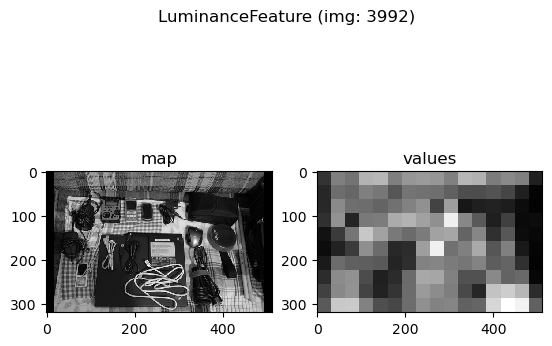

In [5]:
fLum.plot(example_img)

Now that we know how to define a feature based on an ImageSet, let's add another feature, this time investigating the edge density map returned by the Sobel edge detector. Feature values here are defined as the proportion of edges in each region / grid cell (because the edge map is binarized, this is equivalent to the mean of each region): 

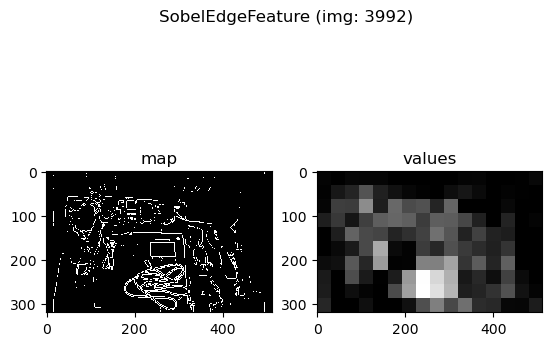

In [6]:
fEdge = SobelEdgeFeature(grid, TA_images)
fEdge.plot(example_img)

## 2. Using pre-generated feature maps

GridFix can, of course, also load predefined feature maps directly from image- or MATLAB files, such as the output maps generated by a saliency model or image segmentation algorithm. In this example, we will use saliency maps created by the well-known saliency model by Itti, Koch & Niebur (1998) [2].

For external feature maps, typically each map corresponds to a single image from the fixation dataset. Therefore, an intuitive way to represent a collection of feature maps is as another ImageSet object (internally, ImageSets are a collection of high-precision floating point matrices). The following example shows a way to load files for an ImageSet that is different from the example in part 1: here, we load a folder containing .mat files and explicitly specify the _imageids_ to assign to each image in the folder. The attribute `mat_var='IKN98'` tells the software to load the _IKN98_ matrix from the specified MATLAB file, allowing to store multiple input maps in the same file:

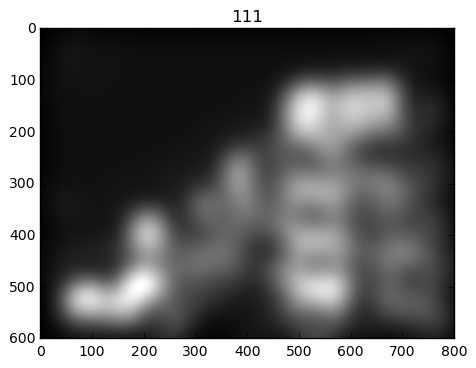

In [7]:
ids = ['112', '67', '6', '52', '37', '106', '129', '9', '107', '97', '58', '111', '85', '149', '150']
maps = ImageSet('maps', imageids=ids, mat_var='IKN98')
maps.plot(example_img)

Now that the IKN98 feature maps have been loaded, we can create a feature to assign each region (grid cell) a unique value based on the input feature map. The corresponding Feature object is called __MapFeature__. This feature object does not transform the input map in any way and simply applies a statistical function to each region. The function to use can be specified in the `stat=` parameter (default is `stat=np.mean` to return the mean feature value per region). All numpy statistics functions work, such as `mean`, `std`, `median` and so on, but this feature will also accept any other function that can process an array and return a scalar. In our example, the following code creates a MapFeature which returns the mean saliency map value in each grid cell:

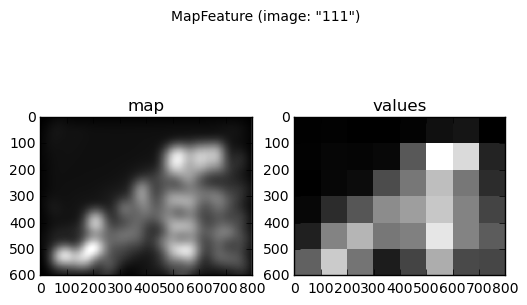

In [8]:
fIKN = MapFeature(grid, maps, stat=np.mean)
fIKN.plot(example_img)

## 3. A special case: the Central Viewing Bias "feature"

When viewing a naturalistic scene on a computer screen, human observers exhibit a strong bias towards the center of the image, even when the center of the image does not even contain the most salient image features or the most information [3]. Even though the assumption of higher fixation probabilities for more central regions is not technically a feature of the input image, central viewing bias can be modeled in GridFix as a special `Feature()` object, the __CentralBiasFeature__. This object type returns the distance between image center and each region's center of gravity (CoG) as its feature values, using one of the following models of central viewing bias: 

- Euclidean distance in pixels
- Gaussian distance measure as proposed in [4], with adjustable $\sigma^2$ and $\nu$ parameters 
- Manhattan- / Taxicab metric (see https://en.wikipedia.org/wiki/Taxicab_geometry)

A CentralBiasFeature can be defined and plotted like any other feature (note that only some variants create an actual feature map, which is not needed for e.g. euclidean distance). For this example, we will use the "gaussian" distance measure, keeping the default parameters suggested by Clarke and Tatler in [3]. As always, you can try other values and observe how they change the feature map.

<gridfix.CentralBiasFeature, length=160, measure "gaussian", sig2=0.23, nu=0.45>
Regions:
	<gridfix.GridRegionSet (TA_images), size=(512, 320), 16x10 grid, 160 cells, memory=25600.0 kB>
Images:
	<gridfix.ImageSet "TA_images", 41 images, size=(512, 320), normalized>


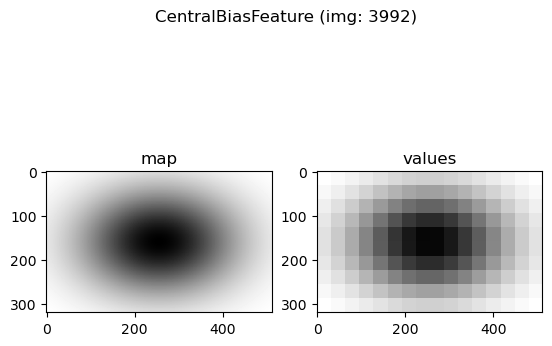

In [7]:
fCent = CentralBiasFeature(grid, TA_images, measure='gaussian', sig2=0.23, nu=0.45)
print(fCent)
fCent.plot(example_img)

## 4. Concluding Remarks

This concludes the second part of our GridFix tutorial. Since we now know how to create and import the image features we want to compare to our participants' fixation data, the next step in this tutorial will explain how to combine all these puzzle pieces into a GLMM predictor matrix and run the resulting model in R. 

## References

[1] Nuthmann, A., & Einhäuser, W. (2015). A new approach to modeling the influence of image features on fixation selection in scenes. Annals of the New York Academy of Sciences, 1339(1), 82-96. http://dx.doi.org/10.1111/nyas.12705

[2] Itti, L., Koch, C. & Niebur, E. (1998). A model of saliency-based visual attention for rapid scene analysis. IEEE Transactions on Pattern Analysis & Machine Intelligence (11), 1254-1259. http://dx.doi.org/10.1109/34.730558

[3] Tatler, B. W. (2007). The central fixation bias in scene viewing: selecting an optimal viewing position independently of motor biases and image feature distributions.  J Vis 7(14), 411-417. http://dx.doi.org/10.1167/7.14.4

[4] Clarke, A. D. F. & Tatler, B. W. (2014). Deriving an appropriate baseline for describing fixation behaviour. Vision Res 102, 41-51. http://dx.doi.org/10.1016/j.visres.2014.06.016